# Learning about control with the Kalman filter

The ideas here are based on [Kruschke, 2008 Bayesian approaches to associative learning](https://link.springer.com/article/10.3758/LB.36.3.210). 

In the Kalman filter, the beliefs of the learner at any given moment can be summarized by the mean vector (mu) and the covariate matrix (C). Learning in the Kalman filter means shifting the degree of belief over all of the possible weight combinations to take into account the observed cues and outcomes. The updated equations for the mean and covariance of the beliefs have the following form (in Matlab syntax):  
  
`delta_mu = [v - c'Cc]^-1 .* (t - mu'c)Cc`  

`delta_C = -[v + c'Cc]^-1 .* Ccc'C`  

Where `t` is the actual outcome, and `c` is the column vector of cues present or absent on each trial (0 or 1). `v` is the outcome variance as well as a _free-parameter_ reflecting whether the environment is dynamic, i.e., in a dynamic environment trials in the distant past have less influence (and in a stationary environment `v = 0`). `C` is the belief uncertainty, and when `C` is larger then learning is faster.

Note that in the updating equation for the mean, `(t - mu'c)` is analagous to the prediction-error in the Rescorla-Wagner rule `(t - w'c)`. The Rescorla-Wagner learning rate (alpha) has been replaced by `[v - c'CC]`. Also note that in the Rescorla-Wagner rule, the weight of absent cues (when `c = 0`) does not change. In the Kalman filter, the delta is governed by the rightmost term (`Cc`), which is the cue vector multiplied by the covariance matrix. This implies that when a cue is absent, the mean weight on the cue might change if other cues are present which are (inversely) correlated with the absent cue.

#### A simulation
We start by defining twenty trial events involving an action and an outcome. The action can occur at random in each of the trials, and the outcome occurs in the same trial as the action half the time.

In [2]:
% trial events
actions = binornd(1, 0.5, 20, 1);
outcomes = binornd(actions, 0.5);
disp('   Trial  Act  Outcome')
disp([[1:20]', actions, outcomes])
disp(['P(O|A) = ', num2str(sum(outcomes.*actions)/sum(actions))])
disp(['P(O|~A) = ', num2str(sum(outcomes.*(1-actions))/sum(1-actions))])

   Trial  Act  Outcome
     1     1     0
     2     0     0
     3     1     0
     4     0     0
     5     1     0
     6     1     1
     7     1     0
     8     1     0
     9     0     0
    10     0     0
    11     1     1
    12     0     0
    13     1     1
    14     1     1
    15     1     0
    16     0     0
    17     0     0
    18     1     1
    19     1     0
    20     1     1

P(O|A) = 0.46154
P(O|~A) = 0


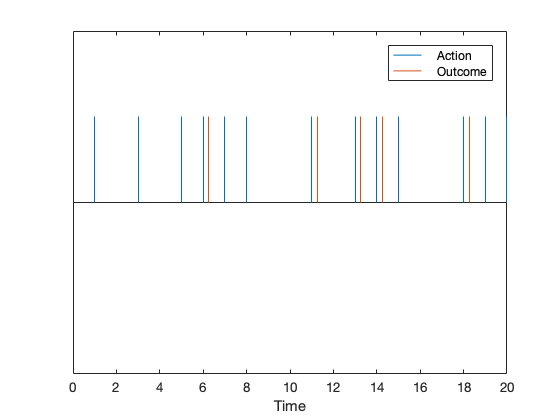

In [3]:
% As a stemplot: action (blue) and a single outcome (red)
x = [[1:20]', [1:20]'+0.25];
y = [actions, outcomes];
stem(x, y, 'Marker','none');
ylim([-2 2])
xlim([0 20])
xlabel('Time')
set(gca,'YTick', [])
legend('Action', 'Outcome')

#### The Kalman filter
Our model begins from the assumption that there is not likely to be any association between the action (or background) and outcome, but if there is then it will be very weak. This starting assumption can be represented as a multivariate normal density between the action and background.

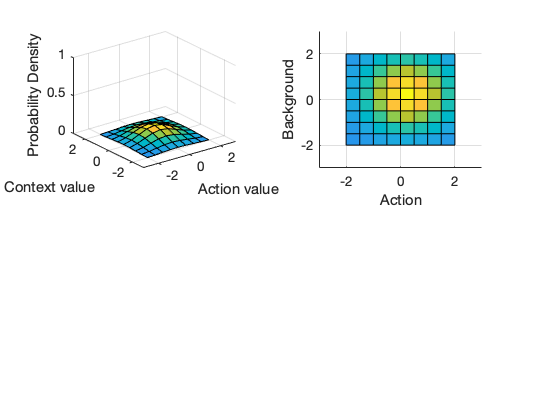

In [4]:
% define variables
alphas = [];
beliefs = [];
uncertainty = [];

% starting values
mu = [0,0]; % cue expected values (beliefs)
C = eye(2); % cue covariance matrix (uncertainty)
v = .5;    % observation uncertainty (how quickly variance reduces with trials)
d = 0;    % process uncertainty (variance floor)

x1 = -2:.5:2; x2 = -2:.5:2;
[X1,X2] = meshgrid(x1,x2);
F = mvnpdf([X1(:) X2(:)], mu, C);
F = reshape(F,length(x2),length(x1));
subplot(2, 2, 1)
surf(x1,x2,F); 
% shading interp
% set(h, 'edgecolor', 1/255*[200,200,200])
caxis([min(F(:))-.5*range(F(:)), max(F(:))]);
axis([-3 3 -3 3 0 1])
xlabel('Action value'); ylabel('Context value'); zlabel('Probability Density');

subplot(2, 2, 2)
surf(x1,x2,F); 
% shading interp
% set(h, 'edgecolor', 1/255*[200,200,200])
caxis([min(F(:))-.5*range(F(:)), max(F(:))]);
axis([-3 3 -3 3 0 1])
xlabel('Action'); ylabel('Background'); zlabel('Probability Density');
view(0,90)

The starting beliefs about the action and background are centred around zero for each. Note the shape of the density (e.g., most clearly seen from above in the right panel) is circular, meaning the model begins with no assumptions as to whether the action and background effects covary. However, the Kalman filter will learn the covariance between both and use it to update both together on each trial. That is, updating the belief about one cue will result in updates to the other cue when the covariance ≠ 0.

In [5]:
% starting values
mu = [0,0]; % cue expected values (beliefs)
C = eye(2); % cue covariance matrix (uncertainty)
v = .5;    % observation uncertainty (how quickly variance reduces with trials)
d = 0;    % process uncertainty (variance floor)

alphas = [];
beliefs = [];
covariance = []; %zeros(2, 2, size(actions,1));

for i = 1:size(actions,1)
    
    c = [actions(i); 1];        % set cue values
    t = outcomes(i);             % set outcome values
    
    PE = (t - mu*c) * C * c;        % prediction-error
    alpha = (v + c' * C * c);       % uncertainty (outcome + expected)
    delta_mu = 1/alpha * PE;      % calculate delta mu
    mu = mu + delta_mu';        % update mu

    
    cmatrix = C * (c*c') * C;       % adjust uncertainty by observed cues
    delta_C = 1/alpha * cmatrix;  % uncertainty reduction by observation
    C = C - delta_C + eye(2)*d;   % update C (reduce uncertainty)   
    
    %% store values
    alphas(end+1) = alpha;
    beliefs(end+1,:) = mu;
    covariance(:, :, i) = C;
       
end

disp(['The final belief in the action is ', num2str(mu(1)), ...
      ', and the background is ', num2str(mu(2))])

The final belief in the action is 0.41763, and the background is 0.027842


We plot how the beliefs are represented by the multivariate normal density below, as well as how they change over time.

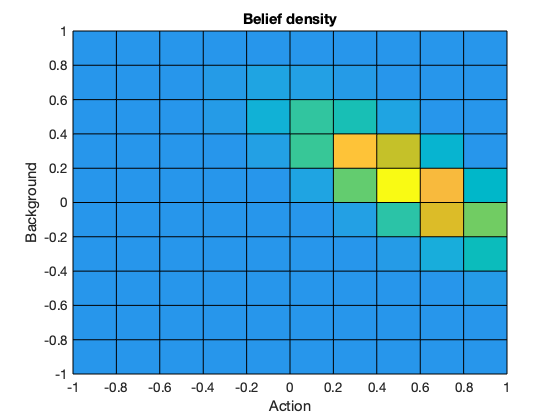

In [6]:
% For plotting
x1 = -1:.2:1; x2 = -1:.2:1;
[X1,X2] = meshgrid(x1,x2);

% pad some zeros at the start to help ease visual understanding
beliefs_padded = [zeros(3, 2); beliefs];
covariance_padded = cat(3, repmat(eye(2), [1, 1, 3]), covariance);

for i = 1:size(beliefs_padded, 1)
    mu = beliefs_padded(i, :);
    C = covariance_padded(:, :, i);
    F = mvnpdf([X1(:) X2(:)], mu, C);
    F = reshape(F,length(x2),length(x1));
    h = figure(1);
    surf(x1,x2,F); 
%     shading interp
    caxis([min(F(:))-.5*range(F(:)), max(F(:))]);
    axis([-1 1 -1 1 0 inf])
    title('Belief density')
    xlabel('Action'); ylabel('Background')
    
    view(0,90)
%     drawnow;
      % Capture the plot as an image
      frame = getframe(h);
      im = frame2im(frame);
      [imind,cm] = rgb2ind(im,256);
      % Write to the GIF File 
      if i == 1 
          imwrite(imind,cm,'contingent.gif','gif', 'LoopCount', Inf, 'DelayTime',.1); 
      else 
          imwrite(imind,cm,'contingent.gif','gif','WriteMode','append', 'DelayTime',.1); 
      end 
      
end

By the end of the final trial, the belief in the action is higher than any belief in the background. Furthermore, the model has learnt that the covariance between the action and background is negative, since the belief in the effect of the action is negatively correlated with the belief in any background effects. It doesn't have to be negative - if the model had not been able to distinguish the effect of the background from the action, then the covariance would have been positive.  

We can view the changes in both beliefs over time

![](contingent.gif)

Note that the centre of mass shifts slightly to the right (from 0) without much shift upwards. Also observe the negative covariance appears almost immediately in this example.

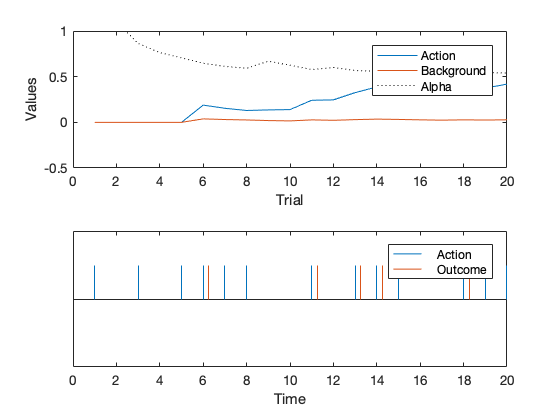

In [9]:
% plot V-values (red is background, blue is action, dotted is total uncertainty)
subplot(2, 1, 1)
plot(beliefs); hold on
plot((alphas/v)./2,'k:'); hold off
ylim([-0.5 1])
xlabel('Trial') 
ylabel('Values')
legend('Action', 'Background', 'Alpha')

% Stemplot of events
x = [[1:20]', [1:20]'+0.25];
y = [actions, outcomes];
subplot(2, 1, 2)
stem(x, y, 'Marker','none');
ylim([-2 2])
xlim([0 20])
xlabel('Time')
set(gca,'YTick', [])
legend('Action', 'Outcome')

Plotting the changes in cue value across trials shows how the model learns about each cue together. Note that in this example, cue 2 occurred without any other events in trial 2, and then both cues occurred with the outcome in trial 3 and the model attributed greater value to cue 1 as a result. This occurred because of the negative covariation detected between cue 1 and cue 2 on trial 2.

Compare to the Rescorla-Wagner model below.

#### The Rescorla-Wagner model

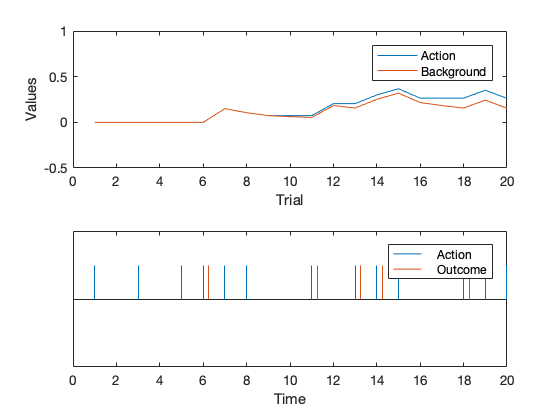

In [10]:
% starting values
alpha = 0.15; w = [0,0];

%% rescorla-wagner model loop
for i = 1:size(actions,1)
    
    c = [actions(i); 1];
    t = outcomes(i);
    
    sumV = w(i,:)*c;
    delta_w = alpha*(t-sumV);
    w(end+1,:) = w(i,:)+delta_w*c';
    
end
    
% plot V-values (red is cue2, blue is cue1)
subplot(2, 1, 1)
plot(w)
ylim([-0.5 1])
xlabel('Trial') 
ylabel('Values') 
xlim([0 20])
legend('Action', 'Background')

% Stemplot of events
x = [[1:20]', [1:20]'+0.25];
y = [actions, outcomes];
subplot(2, 1, 2)
stem(x, y, 'Marker','none');
ylim([-2 2])
xlim([0 20])
xlabel('Time')
set(gca,'YTick', [])
legend('Action', 'Outcome')

Comparing the changes in learning here with the Kalman filter above seems to show they are very similar. This is expected with a single action-outcome contingency.

#### A second simulation
One contingent action with a background effect

In [11]:
actions = binornd(1, 0.5, 20, 1);
outcomes = binornd(1, 0.5, 20, 1); % non-contingent
disp('   Trial  Act  Outcome')
disp([[1:20]', actions, outcomes])
disp(['P(O|A) = ', num2str(sum(outcomes.*actions)/sum(actions))])
disp(['P(O|~A) = ', num2str(sum(outcomes.*(1-actions))/sum(1-actions))])

   Trial  Act  Outcome
     1     0     1
     2     1     0
     3     0     0
     4     0     0
     5     0     0
     6     0     1
     7     0     0
     8     1     0
     9     1     1
    10     1     0
    11     0     1
    12     1     1
    13     0     0
    14     1     0
    15     0     0
    16     1     1
    17     1     0
    18     1     1
    19     0     1
    20     1     1

P(O|A) = 0.5
P(O|~A) = 0.4


In [12]:
% starting values
mu = [0,0]; % cue expected values (beliefs)
C = eye(2); % cue covariance matrix (uncertainty)
v = .5;    % observation uncertainty (how quickly variance reduces with trials)
d = .001;    % process uncertainty (variance floor)

alphas = [];
beliefs = [];
covariance = []; %zeros(2, 2, size(actions,1));

for i = 1:size(actions,1)
    
    c = [actions(i); 1];        % set cue values
    t = outcomes(i);             % set outcome values
    
    PE = (t - mu*c) * C * c;        % prediction-error
    alpha = (v + c' * C * c);       % uncertainty (outcome + expected)
    delta_mu = 1/alpha * PE;      % calculate delta mu
    mu = mu + delta_mu';        % update mu

    
    cmatrix = C * (c*c') * C;       % adjust uncertainty by observed cues
    delta_C = 1/alpha * cmatrix;  % uncertainty reduction by observation
    C = C - delta_C + eye(2)*d;   % update C (reduce uncertainty)   
    
    %% store values
    alphas(end+1) = alpha;
    beliefs(end+1,:) = mu;
    covariance(:, :, i) = C;
       
end

disp(['The final belief in the action is ', num2str(mu(1)), ...
      ', and the background is ', num2str(mu(2))])

The final belief in the action is 0.11214, and the background is 0.40777


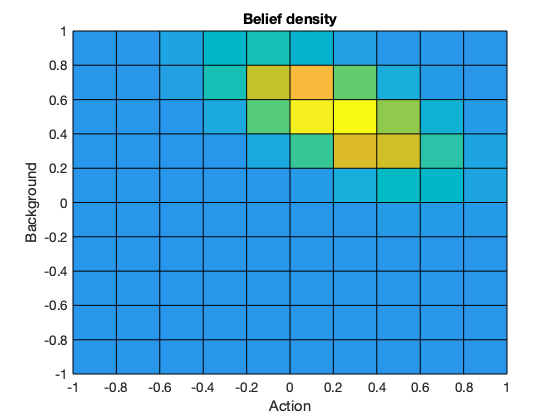

In [13]:
% For plotting
x1 = -1:.2:1; x2 = -1:.2:1;
[X1,X2] = meshgrid(x1,x2);

% pad some zeros at the start to help ease visual understanding
beliefs_padded = [zeros(3, 2); beliefs];
covariance_padded = cat(3, repmat(eye(2), [1, 1, 3]), covariance);

for i = 1:size(beliefs_padded, 1)
    mu = beliefs_padded(i, :);
    C = covariance_padded(:, :, i);
    F = mvnpdf([X1(:) X2(:)], mu, C);
    F = reshape(F,length(x2),length(x1));
    h = figure(1);
    surf(x1,x2,F); 
%     shading interp
    caxis([min(F(:))-.5*range(F(:)), max(F(:))]);
    axis([-1 1 -1 1 0 inf])
    title('Belief density')
    xlabel('Action'); ylabel('Background')
    
    view(0,90)
%     drawnow;
      % Capture the plot as an image
      frame = getframe(h);
      im = frame2im(frame);
      [imind,cm] = rgb2ind(im,256);
      % Write to the GIF File 
      if i == 1 
          imwrite(imind,cm,'noncontingent.gif','gif', 'LoopCount', Inf, 'DelayTime',.1); 
      else 
          imwrite(imind,cm,'noncontingent.gif','gif','WriteMode','append', 'DelayTime',.1); 
      end 
      
end

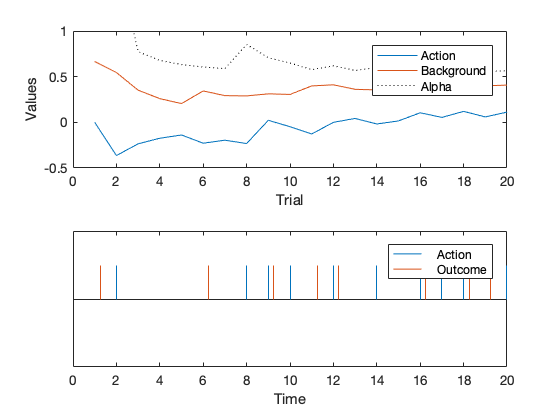

In [14]:
% plot V-values (red is background, blue is action, dotted is total uncertainty)
subplot(2, 1, 1)
plot(beliefs); hold on
plot((alphas/v)./2,'k:'); hold off
ylim([-0.5 1])
xlabel('Trial') 
ylabel('Values')
legend('Action', 'Background', 'Alpha')

% Stemplot of events
x = [[1:20]', [1:20]'+0.25];
y = [actions, outcomes];
subplot(2, 1, 2)
stem(x, y, 'Marker','none');
ylim([-2 2])
xlim([0 20])
xlabel('Time')
set(gca,'YTick', [])
legend('Action', 'Outcome')

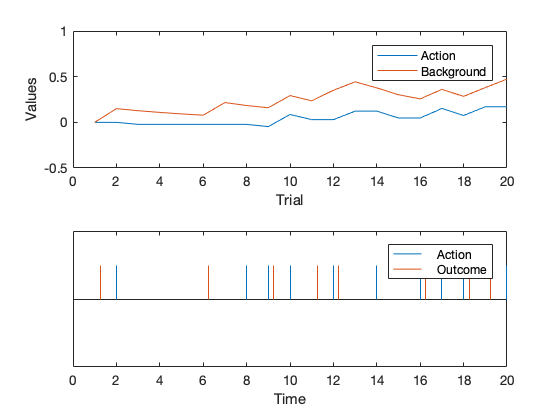

In [15]:
% starting values
alpha = 0.15; w = [0,0];

%% rescorla-wagner model loop
for i = 1:size(actions,1)
    
    c = [actions(i); 1];
    t = outcomes(i);
    
    sumV = w(i,:)*c;
    delta_w = alpha*(t-sumV);
    w(end+1,:) = w(i,:)+delta_w*c';
    
end
    
% plot V-values (red is cue2, blue is cue1)
subplot(2, 1, 1)
plot(w)
ylim([-0.5 1])
xlabel('Trial') 
ylabel('Values') 
xlim([0 20])
legend('Action', 'Background')

% Stemplot of events
x = [[1:20]', [1:20]'+0.25];
y = [actions, outcomes];
subplot(2, 1, 2)
stem(x, y, 'Marker','none');
ylim([-2 2])
xlim([0 20])
xlabel('Time')
set(gca,'YTick', [])
legend('Action', 'Outcome')

#### A third simulation
Two actions, one contingent, with a background effect

In [19]:
action1 = binornd(1, 0.5, 20, 1);
action2 = binornd(1-action1, 0.5); % never occurs with action1
outcomes = binornd(1, 0.5, 20, 1); % non-contingent
disp('   Trial  Act1  Act2  Outcome')
disp([[1:20]', action1, action2, outcomes])
disp(['P(O|A1) = ', num2str(sum(outcomes.*action1)/sum(actions))])
disp(['P(O|~A1) = ', num2str(sum(outcomes.*(1-action1))/sum(1-action1))])

   Trial  Act1  Act2  Outcome
     1     1     0     0
     2     1     0     0
     3     0     0     1
     4     1     0     0
     5     1     0     0
     6     1     0     1
     7     0     0     0
     8     0     1     0
     9     0     1     0
    10     1     0     0
    11     0     1     0
    12     1     0     1
    13     0     1     1
    14     1     0     1
    15     0     0     1
    16     1     0     0
    17     1     0     1
    18     0     0     1
    19     0     0     1
    20     1     0     1

P(O|A1) = 0.5
P(O|~A1) = 0.55556


In [20]:
disp(['P(O|A2) = ', num2str(sum(outcomes.*action2)/sum(actions))])
disp(['P(O|~A2) = ', num2str(sum(outcomes.*(1-action2))/sum(1-action2))])

P(O|A2) = 0.1
P(O|~A2) = 0.5625


In [23]:
% starting values
mu = [0,0,0]; % cue expected values (beliefs)
C = eye(3); % cue covariance matrix (uncertainty)
v = .5;    % observation uncertainty (how quickly variance reduces with trials)
d = .001;    % process uncertainty (variance floor)

alphas = [];
beliefs = [];
covariance = []; %zeros(2, 2, size(actions,1));

for i = 1:size(outcomes,1)
    
    c = [action1(i); action2(i); 1];        % set cue values
    t = outcomes(i);             % set outcome values
    
    PE = (t - mu*c) * C * c;        % prediction-error
    alpha = (v + c' * C * c);       % uncertainty (outcome + expected)
    delta_mu = 1/alpha * PE;      % calculate delta mu
    mu = mu + delta_mu';        % update mu

    
    cmatrix = C * (c*c') * C;       % adjust uncertainty by observed cues
    delta_C = 1/alpha * cmatrix;  % uncertainty reduction by observation
    C = C - delta_C + eye(3)*d;   % update C (reduce uncertainty)   
    
    %% store values
    alphas(end+1) = alpha;
    beliefs(end+1,:) = mu;
    covariance(:, :, i) = C;
       
end

% disp(['The final belief in the action is ', num2str(mu(1)), ...
%       ', and the background is ', num2str(mu(2))])

disp(mu)

   -0.1858   -0.3693    0.6999



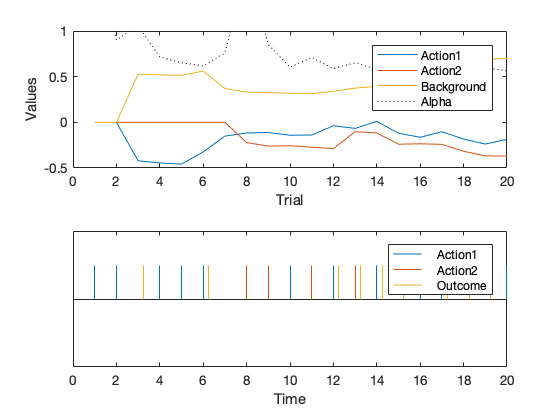

In [28]:
% plot V-values (red is background, blue is action, dotted is total uncertainty)
subplot(2, 1, 1)
plot(beliefs); hold on
plot((alphas/v)./2,'k:'); hold off
ylim([-0.5 1])
xlabel('Trial') 
ylabel('Values')
legend('Action1', 'Action2', 'Background', 'Alpha')

% Stemplot of events
x = [[1:20]', [1:20]', [1:20]'+0.25];
y = [action1, action2, outcomes];
subplot(2, 1, 2)
stem(x, y, 'Marker','none');
ylim([-2 2])
xlim([0 20])
xlabel('Time')
set(gca,'YTick', [])
legend('Action1', 'Action2', 'Outcome')